# Sprint1 機械学習フロー

事前準備

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #データを分割する
from sklearn import preprocessing
import missingno as msno

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 130)

In [2]:
train_df = pd.read_csv("application_train.csv") #訓練用データ
train_df = train_df[0:15000]
# print(train_df.shape)
df = train_df

new_df = df.loc[df['TARGET'] == 1, 'DAYS_BIRTH'] / 365
new_df = new_df.rename('NEW_DAYS_BIRTH')


# display(train_df.loc[:,["CODE_GENDER","FLAG_OWN_CAR","AMT_CREDIT","AMT_ANNUITY"]].head())

# 1.CODE_GENDERを数値化する
gender_mapping = {'M': 0, 'F': 1}
train_df['CODE_GENDER'] = train_df['CODE_GENDER'].map(gender_mapping)

# 2."FLAG_OWN_CAR"を数値化する
flag_mapping = {'N': float(0), 'Y': float(1)}
train_df["FLAG_OWN_CAR"] = train_df["FLAG_OWN_CAR"].map(flag_mapping)

# 3.train_dfから"AMT_CREDIT","AMT_ANNUITY"を抜き取る
x_df = train_df.loc[:,["CODE_GENDER","FLAG_OWN_CAR","AMT_CREDIT","AMT_ANNUITY","DAYS_BIRTH"]]
t_df = train_df.loc[:,["TARGET"]]

# 4.結合 説明変数と目的変数を絞ったdataframe
train_df = pd.concat([x_df, t_df], axis=1)

train_df = pd.concat([train_df, new_df], axis=1)

# train_df.rename(0:"NEW_DAY_BIRTH")

# print(train_df.head())


# 5.欠損値を削除
# train_df = train_df.dropna(how='any',axis=0) #欠損値ありの行 削除
train_df = train_df.fillna(train_df.mean())

print('ndarrayへ変換直前のDataFrame')
display(train_df.head())

# 6.ndarrayへ変換  性別・車を持っているか・ローンクレジット額・ローン年金 ４項目に絞る
x = train_df.loc[:,["CODE_GENDER","FLAG_OWN_CAR","AMT_CREDIT","AMT_ANNUITY","DAYS_BIRTH"]].values
t = train_df["TARGET"].values #to_numpyだとmethodになる（？）

print(t)

ndarrayへ変換直前のDataFrame


,CODE_GENDER,FLAG_OWN_CAR,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,TARGET,NEW_DAYS_BIRTH
0,0,0.0,406597.5,24700.5,-9461,1,-25.920548
1,1,0.0,1293502.5,35698.5,-16765,0,-40.176612
2,0,1.0,135000.0,6750.0,-19046,0,-40.176612
3,1,0.0,312682.5,29686.5,-19005,0,-40.176612
4,0,0.0,513000.0,21865.5,-19932,0,-40.176612


[1 0 0 ... 0 0 0]


# 機械学習フロー

1回目のSprintでは、機械学習の実践的な流れを抑えます。このSprintはWeek3,4の延長になり、

引き続きKaggleの Home Credit Default Risk コンペティションを用います。

特にここでは適切な **検証** を組み込むことを重視し、その上で前処理やモデルの選定を進めていきます。


適切な検証を行い、テストデータに対して高い汎化性能を持つモデルを完成させましょう。


## 【問題1】クロスバリデーション

事前学習期間は検証データを分割しておき、それに対して指標値を計算することで検証を行っていました。

しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。


具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。


sklearn.model_selection.KFold — scikit-learn 0.20.2 documentation



In [3]:
from sklearn.model_selection import KFold

# Kfoldで学習用、テスト用へ分割
kf = KFold(n_splits=3) #4分割 データの分割数k．検定はここで指定した数値の回数おこなわれる(train75%:test25%)
kf.get_n_splits(x, t)

for train_index, test_index in kf.split(x, t):
    print(f'TRAIN:{train_index} TEST:{test_index}')
    x_train, x_test = x[train_index], x[test_index]
    t_train, t_test = t[train_index], t[test_index]
# x_train(7500, 4) x_test(2500, 4) t_train(7500,) t_test(2500,)
print(sum(t_train==0))
print(sum(t_test==0))

TRAIN:[ 5000  5001  5002 ... 14997 14998 14999] TEST:[   0    1    2 ... 4997 4998 4999]
TRAIN:[    0     1     2 ... 14997 14998 14999] TEST:[5000 5001 5002 ... 9997 9998 9999]
TRAIN:[   0    1    2 ... 9997 9998 9999] TEST:[10000 10001 10002 ... 14997 14998 14999]
9225
4601


## 【問題2】グリッドサーチ

これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。

パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。

パラメータを探索するために **グリッドサーチ** と呼ばれる総当たり的手法が一般的に利用されます。


グリッドサーチをパイプラインの中に組み込みましょう。

In [4]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

print(np.unique(x_train))
print(np.unique(t_train))
print(x_train.shape)
print(t_train.shape)

# サポートベクターマシン
clf = svm.SVC()
print(clf)
clf.fit(x_train, t_train)
clf_pre = clf.predict(x_test)
print(f'SVMの正解率 : {clf.score(x_test, t_test)}')

parameter = {
      'C':[0.1, 10, 100, 1000],
      'gamma':np.linspace(0.01, 1.0, 3)
}

# # グリッドサーチCVのインスタンス作成
grid_seach = GridSearchCV(clf, parameter, cv=4, verbose=2)
grid_seach.fit(x_train, t_train) #学習

best = grid_seach.best_estimator_
best_pred = best.predict(x_test)
print(f'グリッドサーチの結果 bestscore : {best_pred}') #ベスト内容
print(f'正解率{grid_seach.score(x_test, t_test)}') # SVC(C=0.1, gamma=0.01)
print(f'グリッドサーチの結果 : ベストなパラメーター : {best}')

[ -25160.  -25122.  -25104. ... 2695500. 2925000. 2961000.]
[0 1]
(10000, 5)
(10000,)
SVC()
SVMの正解率 : 0.9202
Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END ..................................C=0.1, gamma=0.01; total time=   3.8s
[CV] END ..................................C=0.1, gamma=0.01; total time=   3.8s
[CV] END ..................................C=0.1, gamma=0.01; total time=   3.8s
[CV] END ..................................C=0.1, gamma=0.01; total time=   3.8s
[CV] END .................................C=0.1, gamma=0.505; total time=   4.5s
[CV] END .................................C=0.1, gamma=0.505; total time=   4.3s
[CV] END .................................C=0.1, gamma=0.505; total time=   4.3s
[CV] END .................................C=0.1, gamma=0.505; total time=   4.3s
[CV] END ...................................C=0.1, gamma=1.0; total time=   4.3s
[CV] END ...................................C=0.1, gamma=1.0; total time=   4.3s
[CV] END ...........

In [8]:
# 当初      SVMの正解率 : 0.921
# グリッドサーチ 正解率0.9216


# グリッドサーチでベストなパラメータに変えた
clf = svm.SVC(C=0.1, gamma=0.01)
print(clf)
clf.fit(x_train, t_train)
clf_pre_best = clf.predict(x_test)
print(f'SVMの正解率 : {clf.score(x_test, t_test)}')
# あまり変わらず小数点4くらいで変化

SVC(C=0.1, gamma=0.01)
SVMの正解率 : 0.9202


## 【問題3】Kernelからの調査

KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。

そして、効果があると考えられるものを検証してください。



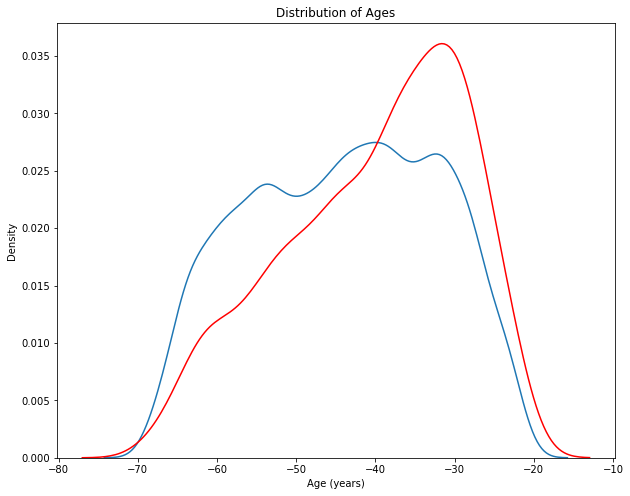

In [6]:
# 年齢に関する考察は自分でも行なっていたが、Kaggle上位者の考察は色々と深い分析があった
# ・下のグラフは縦軸が密度、横軸が年齢
# 赤い線はターゲット1を表しており、20~30代に大きく傾斜があり密度が濃いことがわかる。
# また、年齢が高くなるにあたりその傾斜が低くなっており、40代以上はターゲット０の方が割合がおおい。
# 年齢別のローン返済の失敗について調査するのもあり

plt.figure(figsize = (10, 8))

sns.kdeplot(df.loc[df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label ='target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label ='target == 1', color="red")
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.show()

## 【問題4】高い汎化性能のモデル


これまで学んだことを用いながら汎化性能の高いモデルを作成してください。

今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すということも意識しましょう。

<class 'pandas.core.series.Series'>


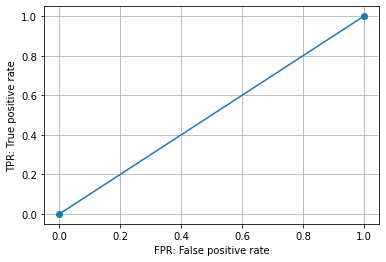

auc : 0.5


In [10]:
n = df.loc[df['TARGET'] == 1, 'DAYS_BIRTH'] / 365
print(type(n))

# 変更前のモデル
from sklearn.metrics import roc_curve, auc, accuracy_score
roc = roc_curve(t_test, clf_pre_best)
fpr, tpr, thresholds = roc_curve(t_test, clf_pre)

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()
print(f'auc : {auc(fpr, tpr)}')

In [ ]:
# 前回はランダムフォレスト、今回はSVMを実装したがあまり数値は上がっていない